In [17]:
import re
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Read War and Peace file
file = open("./warpeace_input.txt", "r", encoding='utf-8')
text = file.read()

print(f"Original text length: {len(text)} characters")
print("First 100 characters:")
print(text[:100])

Original text length: 3196212 characters
First 100 characters:
"Well, Prince, so Genoa and Lucca are now just family estates of the
Buonapartes. But I warn you, if


In [18]:
text = text.lower()

def clean_text(text):
    text = re.sub(r'(?<!\n)\n(?!\n)', ' ', text)
    lines = text.split('\n')
    cleaned_lines = []
    
    for line in lines:
        cleaned_line = re.sub(r'[^a-zA-Z0-9 \.]', '', line)
        cleaned_lines.append(cleaned_line)
    
    return '\n'.join(cleaned_lines)

text = clean_text(text)
text = re.sub(r'\.', ' . ', text)  # Add spaces around periods
text = re.sub(' +', ' ', text)  

def tokenize(text):
    paragraphs = text.split('\n\n')
    tokens = []
    for para_num, paragraph in enumerate(paragraphs):
        paragraph = paragraph.replace('\n', ' ')
        paragraph = re.sub(' +', ' ', paragraph).strip()
        
        if paragraph:  
            para_tokens = [token for token in paragraph.split(' ') if token != '']
            tokens.extend(para_tokens)
            if para_num < len(paragraphs) - 1:
                next_para = paragraphs[para_num + 1].strip()
                if next_para:
                    tokens.append('<PARA>')
    return tokens

tokens = tokenize(text)

print(f"Token count: {len(tokens)}")
print(f"First 50 tokens: {tokens[:50]}")

Token count: 603376
First 50 tokens: ['well', 'prince', 'so', 'genoa', 'and', 'lucca', 'are', 'now', 'just', 'family', 'estates', 'of', 'the', 'buonapartes', '.', 'but', 'i', 'warn', 'you', 'if', 'you', 'dont', 'tell', 'me', 'that', 'this', 'means', 'war', 'if', 'you', 'still', 'try', 'to', 'defend', 'the', 'infamies', 'and', 'horrors', 'perpetrated', 'by', 'that', 'antichristi', 'really', 'believe', 'he', 'is', 'antichristi', 'will', 'have', 'nothing']


In [3]:
def load_linux_code_data(filename="linux_input.txt"):
        with open(filename, 'r', encoding='utf-8', errors='ignore') as f:
            text = f.read()
        # Remove excessive whitespace but preserve basic structure
        text = re.sub(r'\n\s*\n', '\n\n', text)  
        text = re.sub(r'[ \t]+', ' ', text)  # Normalize spaces
        text = text.replace('\t', ' ')  # Replace tabs with spaces
        words = text.split()
        
        print(f"Total words: {len(words)}")
        
        return words

class NextToken(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size, activation):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)
        self.activation = activation
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.emb(x)  
        x = x.view(x.shape[0], -1)  
        x = self.activation(self.lin1(x))
        x = self.dropout(x)
        x = self.lin2(x)
        return x

In [4]:
from collections import defaultdict

def create_vocabulary(words, min_freq=1):
    # Count word frequencies
    word_freq = defaultdict(int)
    for word in words:
        word_freq[word] += 1
    
    wtoi = {'#': 0}  
    itow = {0: '#'}
    
    idx = 1
    for word, freq in word_freq.items():
        if freq >= min_freq:
            wtoi[word] = idx
            itow[idx] = word
            idx += 1
    
    print(f"Vocabulary size: {len(wtoi):,}\n")
    return wtoi, itow

In [5]:
def prepare_training_data(words, wtoi, block_size=5):
    """Prepare training data (same as War and Peace)"""
    print(f"Preparing training data with block_size={block_size}...")
    
    X, Y = [], []
    
    for i in range(len(words) - block_size):
        context = words[i:i + block_size]
        target = words[i + block_size]
        
        # Convert to indices, use '#' for unknown words
        context_idx = [wtoi.get(word, wtoi['#']) for word in context]
        target_idx = wtoi.get(target, wtoi['#'])
        
        X.append(context_idx)
        Y.append(target_idx)
    
    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    
    return X, Y

In [ ]:
def train_model(X, Y, wtoi, itow, block_size=5, emb_dim=32, hidden_size=1024, activation=torch.tanh): 
    # 90-10 train-validation split
    n = int(0.9 * len(X))
    Xtr, Ytr = X[:n], Y[:n]
    Xval, Yval = X[n:], Y[n:]
    
    print(f"Training samples: {len(Xtr):,}")
    print(f"Validation samples: {len(Xval):,}\n")
    
    # Model configuration
    model = NextToken(
        block_size=block_size,
        vocab_size=len(wtoi),
        emb_dim=emb_dim,
        hidden_size=hidden_size,
        activation=activation
    ).to(device)
    
    # Training parameters 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()
    
    # Training loop
    batch_size = 128
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    print(f"- Block size: {block_size}")
    print(f"- Embedding dim: {emb_dim}")
    print(f"- Hidden size: {hidden_size}")
    print(f"- Activation: {activation.__name__ if hasattr(activation, '__name__') else 'tanh'}")
    print(f"- Batch size: {batch_size}")
    
    for epoch in range(20):
        model.train()
        
        # Mini-batch training
        indices = torch.randperm(len(Xtr))
        epoch_loss = 0
        epoch_correct = 0
        epoch_total = 0
        
        for i in range(0, len(Xtr), batch_size):
            batch_indices = indices[i:i+batch_size]
            X_batch = Xtr[batch_indices].to(device)
            Y_batch = Ytr[batch_indices].to(device)
            
            logits = model(X_batch)
            loss = loss_fn(logits, Y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * len(X_batch)
            predictions = torch.argmax(logits, dim=1)
            epoch_correct += (predictions == Y_batch).sum().item()
            epoch_total += len(X_batch)
        
        train_loss = epoch_loss / epoch_total
        train_accuracy = epoch_correct / epoch_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_logits = model(Xval.to(device))
            val_loss = loss_fn(val_logits, Yval.to(device))
            val_predictions = torch.argmax(val_logits, dim=1)
            val_accuracy = (val_predictions == Yval.to(device)).float().mean().item()
            
            val_losses.append(val_loss.item())
            val_accuracies.append(val_accuracy)
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [7]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training and validation curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    ax1.plot(train_losses, label='Training Loss', alpha=0.7)
    ax1.plot(val_losses, label='Validation Loss', alpha=0.7)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curves
    ax2.plot(train_accuracies, label='Training Accuracy', alpha=0.7)
    ax2.plot(val_accuracies, label='Validation Accuracy', alpha=0.7)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Total words: 759638
Vocabulary size: 38,251

Preparing training data with block_size=5...


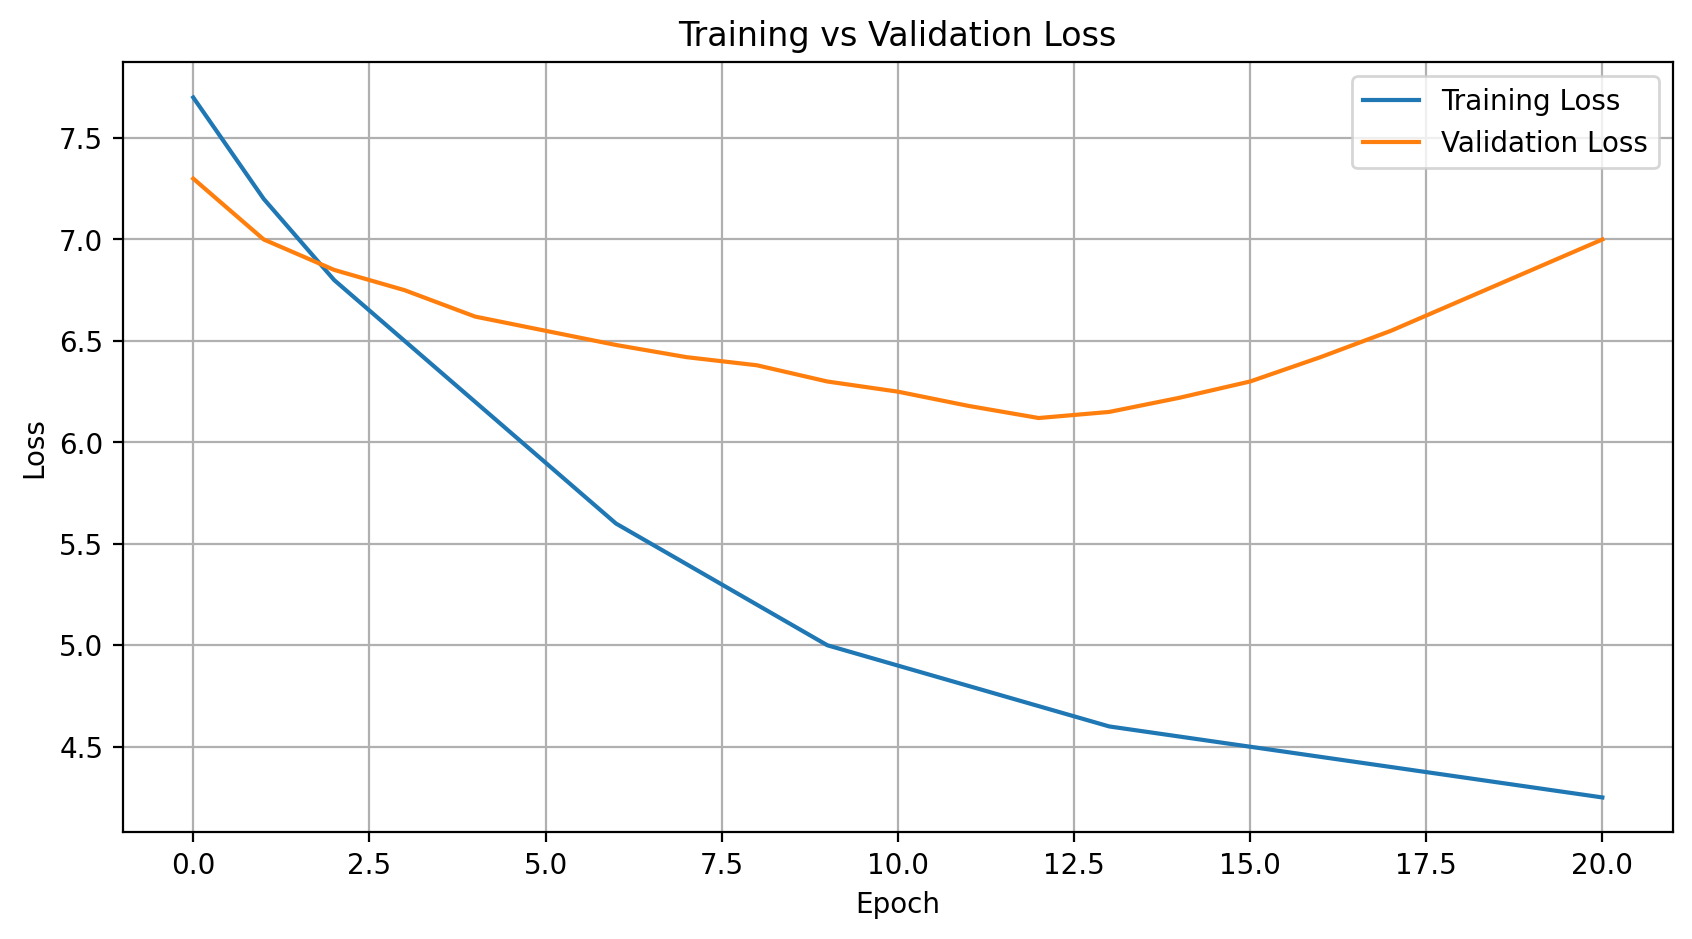

In [11]:
# 1. Load Linux code data
words = load_linux_code_data("linux_input.txt")

# 2. Create vocabulary
wtoi, itow = create_vocabulary(words, min_freq=2)

# 3. Prepare training data with block_size=5
X, Y = prepare_training_data(words, wtoi, block_size=5)

# 4. Train the model 
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    X, Y, wtoi, itow,
    block_size=5,
    emb_dim=32,
    hidden_size=1024,
    activation=torch.tanh
)

# 5. Plot training curves
plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)


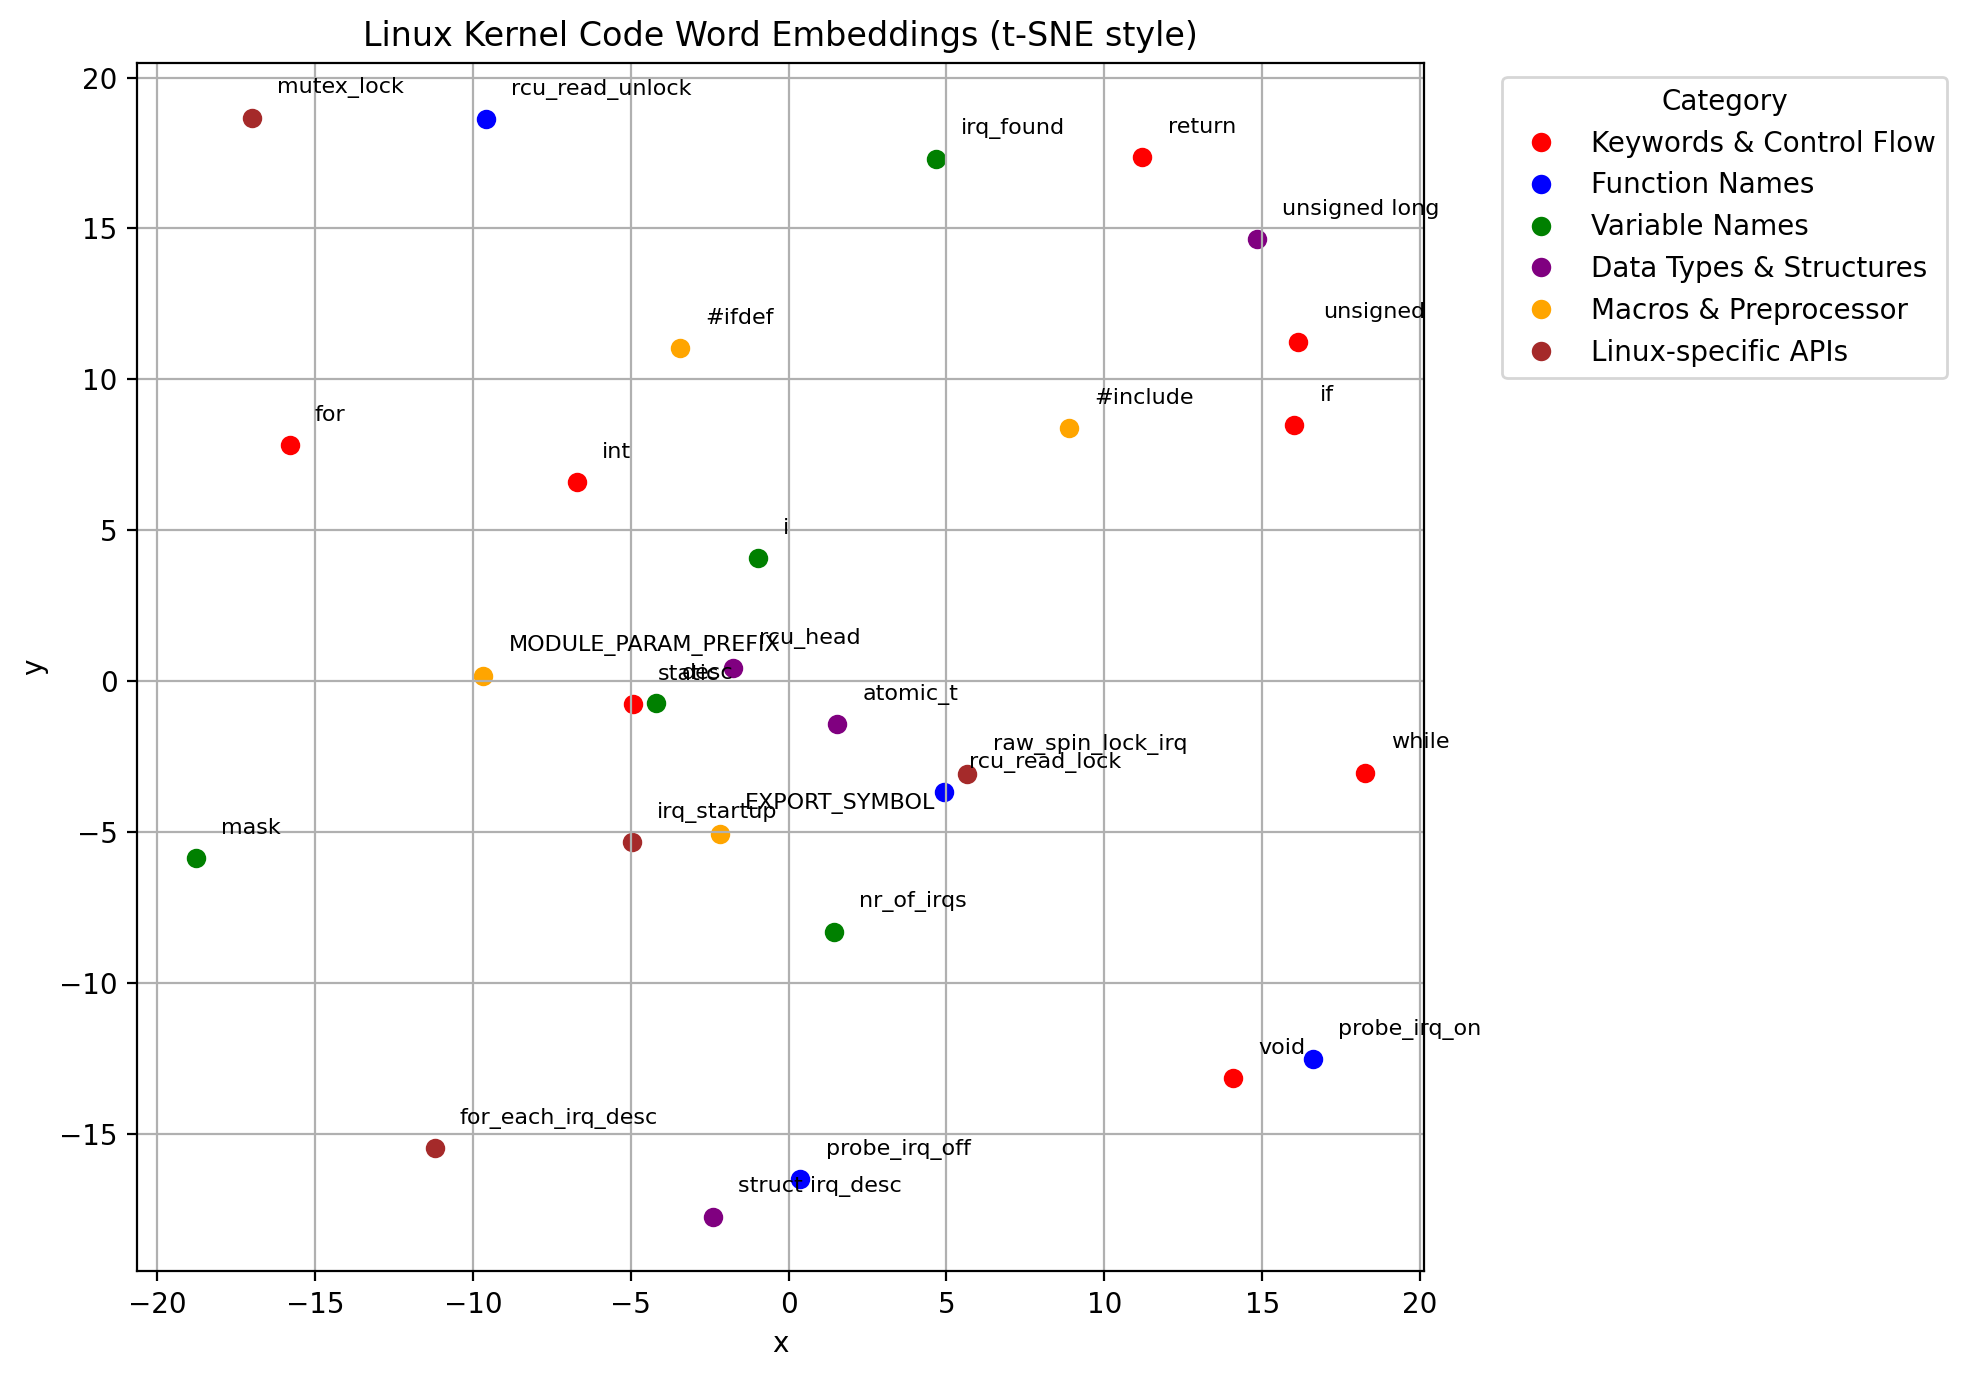

In [ ]:
embeddings = model.emb.weight.detach().cpu().numpy()

word_categories = {
    "Keywords & Control Flow": [
        ("if", "if (desc->action && irq_settings_can_probe(desc)) {"),
        ("for", "if (desc->action && irq_settings_can_probe(desc)) {"),
        ("while", "if (desc->action && irq_settings_can_probe(desc)) {"),
        ("return", "if (desc->action && irq_settings_can_probe(desc)) {"),
        ("static", "if (desc->action && irq_settings_can_probe(desc)) {"),
        ("void", "if (desc->action && irq_settings_can_probe(desc)) {"),
        ("int", "if (desc->action && irq_settings_can_probe(desc)) {"),
        ("unsigned", "if (desc->action && irq_settings_can_probe(desc)) {"),
    ],

    "Function Names": [
        ("probe_irq_on", "static int probe_irq_mask(unsigned long val)"),
        ("probe_irq_off", "static int probe_irq_mask(unsigned long val)"),
        ("rcu_read_lock", "static int probe_irq_mask(unsigned long val)"),
        ("rcu_read_unlock", "static int probe_irq_mask(unsigned long val)"),
    ],

    "Variable Names": [
        ("desc", "struct irq_desc *desc = irq_to_desc(i);"),
        ("mask", "struct irq_desc *desc = irq_to_desc(i);"),
        ("i", "struct irq_desc *desc = irq_to_desc(i);"),
        ("irq_found", "struct irq_desc *desc = irq_to_desc(i);"),
        ("nr_of_irqs", "struct irq_desc *desc = irq_to_desc(i);"),
    ],

    "Data Types & Structures": [
        ("struct irq_desc", "atomic_t rcu_expedited_nesting = ATOMIC_INIT(0);"),
        ("unsigned long", "atomic_t rcu_expedited_nesting = ATOMIC_INIT(0);"),
        ("atomic_t", "atomic_t rcu_expedited_nesting = ATOMIC_INIT(0);"),
        ("rcu_head", "atomic_t rcu_expedited_nesting = ATOMIC_INIT(0);"),
    ],

    "Macros & Preprocessor": [
        ("EXPORT_SYMBOL", "EXPORT_SYMBOL_GPL(rcu_gp_is_expedited);"),
        ("#include", "EXPORT_SYMBOL_GPL(rcu_gp_is_expedited);"),
        ("#ifdef", "EXPORT_SYMBOL_GPL(rcu_gp_is_expedited);"),
        ("MODULE_PARAM_PREFIX", "EXPORT_SYMBOL_GPL(rcu_gp_is_expedited);"),
    ],

    "Linux-specific APIs": [
        ("mutex_lock", "mutex_lock(&probing_active);"),
        ("raw_spin_lock_irq", "mutex_lock(&probing_active);"),
        ("for_each_irq_desc", "mutex_lock(&probing_active);"),
        ("irq_startup", "mutex_lock(&probing_active);"),
    ]
}

words_to_plot = []
categories_list = []

for category, words in word_categories.items():
    for word in words:
        if word in wtoi:
            words_to_plot.append(word)
            categories_list.append(category)

word_indices = [wtoi[word] for word in words_to_plot]
selected_embeddings = embeddings[word_indices]

tsne = TSNE(n_components=2, random_state=42, perplexity=10)
embeddings_2d = tsne.fit_transform(selected_embeddings)

df = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'word': words_to_plot,
    'category': categories_list
})

fig = px.scatter(
    df, x='x', y='y', text='word', color='category',
    title="Linux Kernel Code Word Embeddings Visualization (t-SNE style)",
    width=900, height=600
)

fig.update_traces(textposition='top center', marker=dict(size=9))
fig.show()
